In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import warnings
import os

In [2]:
a1 = pd.read_excel("C:\\Users\\User\\Desktop\\Project 2M\\Credit\\case_study1.xlsx")
a2 = pd.read_excel("C:\\Users\\User\\Desktop\\Project 2M\\Credit\\case_study2.xlsx")

In [3]:
df1 = a1.copy()
df2 = a2.copy()

In [4]:
df1.shape

(51336, 26)

# Missing data handling

# here in both dataframes -99999 means missing values which was filled by datamaker hence we need to do something of that 

In [5]:
df1 = df1.loc[df1['Age_Oldest_TL'] != -99999]

In [6]:
df1.shape   # shape got reduced

(51296, 26)

# similarily for df2 also but there are many present in different columns

In [7]:
columns_to_be_removed = []

In [8]:
for i in df2.columns:
    if df2.loc[df2[i] == -99999].shape[0] > 10000:
        columns_to_be_removed .append(i)

In [9]:
len(columns_to_be_removed)   # 8 columns found where we have -99999 entry

8

In [10]:
columns_to_be_removed

['time_since_first_deliquency',
 'time_since_recent_deliquency',
 'max_delinquency_level',
 'max_deliq_6mts',
 'max_deliq_12mts',
 'CC_utilization',
 'PL_utilization',
 'max_unsec_exposure_inPct']

In [11]:
df2.drop(columns = columns_to_be_removed, axis = 1, inplace = True)  # dropped 8 columns

In [12]:
df2.shape

(51336, 54)

In [13]:
for i in df2.columns:
    df2 = df2.loc[ df2[i] != -99999 ]   # removed -99999 from df2 also

In [14]:
df2.shape

(42066, 54)

In [15]:
df2.isna().sum().sum()  # no null values in any df1 or df2

0

# now we need to merge both dataframes on a common column

In [16]:
for i in list(df1.columns):
    if i in list(df2.columns):
        print(i)

PROSPECTID


# PROSPECTID is the common column in both dataframe hence join both dataframes on PROSPECTID

# # Merge the two dataframes, inner join(inner join is like intersection so only common rows would be there) so that no nulls are present

In [17]:
df = pd.merge(df1, df2, how = 'inner', left_on = ['PROSPECTID'], right_on = ['PROSPECTID'])

In [18]:
df.shape

(42064, 79)

In [19]:
df.isna().sum().sum()  # no null values in full dataframe

0

In [20]:
# check how many columns are categorical
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)

MARITALSTATUS
EDUCATION
GENDER
last_prod_enq2
first_prod_enq2
Approved_Flag


# ckeck for association of MARITALSTATUS, EDUCATION, GENDER, last_prod_enq2, first_prod_enq2 with Approved_Flag(target column) with the help of chi_sqaure test and contingency table

# chi_square_test

# Ho = No association between columns under test
# H1 = Association between columns under test

In [21]:
pd.crosstab(df['GENDER'], df['Approved_Flag'])  # make contingency table like this

Approved_Flag,P1,P2,P3,P4
GENDER,,,,
F,451,2946,744,578
M,4457,22506,5696,4686


In [22]:
for i in ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']:
    chi2, pval, _, _ = chi2_contingency(pd.crosstab(df[i], df['Approved_Flag']))
    print(i, '---', pval)

MARITALSTATUS --- 3.578180861038862e-233
EDUCATION --- 2.6942265249737532e-30
GENDER --- 1.907936100186563e-05
last_prod_enq2 --- 0.0
first_prod_enq2 --- 7.84997610555419e-287


# all p_value <= 0.05 hence each 5 column is significant

# now check for numerical column

In [23]:
numeric_columns = []

In [24]:
for i in df.columns:
    if df[i].dtype != 'object' and i not in ['PROSPECTID','Approved_Flag']:
        numeric_columns.append(i)

In [25]:
len(numeric_columns)   # found 72 numeric columns 

72

# now we check for multicollinearity or correlation between features

# why calculation of correlation is not of significance here? 
# because we are not sure whether features are linearly associated or not hence VIF for multicollearity is better option to choose
# also corr gives misleading values for convex function 

# VIF(Variance inflation Factor) = 1 / 1-r2_score     r2_score of each features by other features 
# VIF measures predictability of each features by other features 
# Value	           Interpretation
# 1	               No multicollinearity (ideal)
# 1–5	           Moderate correlation, acceptable
# 5–10	           High correlation, potential problem
# > 10	           Serious multicollinearity — fix needed

In [26]:
vif_data = df[numeric_columns]          # DataFrame with numeric features only
total_columns = vif_data.shape[1]       # Total number of numeric columns
columns_to_be_kept = []                 # To store selected features
column_index = 0                        # Index to track current column

In [27]:
for i in range (0,total_columns):
    
    vif_value = variance_inflation_factor(vif_data, column_index)
    print (column_index,'---',vif_value)
    
    
    if vif_value <= 6:
        columns_to_be_kept.append( numeric_columns[i] )
        column_index = column_index+1
    
    else:
        vif_data = vif_data.drop([ numeric_columns[i] ] , axis=1)


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf
0 --- 11.320180023967996
0 --- 8.363698035000336
0 --- 6.520647877790928
0 --- 5.149501618212625
1 --- 2.611111040579735


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


2 --- inf
2 --- 1788.7926256209232
2 --- 8.601028256477228
2 --- 3.8328007921530785
3 --- 6.099653381646731
3 --- 5.5813520096427585
4 --- 1.9855843530987785


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


5 --- inf
5 --- 4.809538302819343
6 --- 23.270628983464636
6 --- 30.595522588100053
6 --- 4.384346405965587
7 --- 3.064658415523423
8 --- 2.898639771299251
9 --- 4.377876915347322
10 --- 2.2078535836958433
11 --- 4.916914200506864
12 --- 5.214702030064725
13 --- 3.3861625024231476
14 --- 7.840583309478997
14 --- 5.255034641721438


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


15 --- inf
15 --- 7.380634506427238
15 --- 1.4210050015175733
16 --- 8.083255010190316
16 --- 1.6241227524040112
17 --- 7.257811920140003
17 --- 15.59624383268298
17 --- 1.8258570471324314
18 --- 1.5080839450032664
19 --- 2.172088834824577
20 --- 2.623397553527229
21 --- 2.2959970812106176
22 --- 7.360578319196439
22 --- 2.160238777310255
23 --- 2.8686288267891467
24 --- 6.458218003637272
24 --- 2.8474118865638256
25 --- 4.753198156284083
26 --- 16.227354755948223
26 --- 6.424377256363872
26 --- 8.887080381808687
26 --- 2.3804746142952653
27 --- 8.609513476514548
27 --- 13.06755093547673
27 --- 3.500040056654654
28 --- 1.908795587481377
29 --- 17.006562234161628
29 --- 10.730485153719197
29 --- 2.3538497522950275
30 --- 22.104855915136433
30 --- 2.7971639638512906
31 --- 3.424171203217696
32 --- 10.175021454450912
32 --- 6.408710354561296
32 --- 1.0011511962625628
33 --- 3.069197305397274
34 --- 2.8091261600643724
35 --- 20.249538381980678
35 --- 15.864576541593774
35 --- 1.83316497405

# some repetition is there in above output-- it is dropping and iterating to other columns to come at its place untill the incoming column has vif less than 6
# after this step now we have come down to 39 from 72 columns 

# now we will do Anova test to check for assocition of reduced columns(features) with the target column

# One Way Anova Test

In [28]:
from scipy.stats import f_oneway

In [29]:
columns_to_be_kept_numerical = []

In [30]:
for i in columns_to_be_kept:          # previous column where 39 entries were there
    a = list(df[i])  
    b = list(df['Approved_Flag'])  
    
    group_P1 = [value for value, group in zip(a, b) if group == 'P1']
    group_P2 = [value for value, group in zip(a, b) if group == 'P2']
    group_P3 = [value for value, group in zip(a, b) if group == 'P3']
    group_P4 = [value for value, group in zip(a, b) if group == 'P4']


    f_statistic, p_value = f_oneway(group_P1, group_P2, group_P3, group_P4)

    if p_value <= 0.05:
        columns_to_be_kept_numerical.append(i)

In [31]:
len(columns_to_be_kept_numerical) # now we have reduced to 37 from 39 by doing one way anova

37

In [32]:
df.shape

(42064, 79)

# now feature selection is done for cat and num features

# listing all the final features

In [33]:
features = columns_to_be_kept_numerical + ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']
df = df[features + ['Approved_Flag']]

In [34]:
df.shape

(42064, 43)

# Label encoding for the categorical features ['MARITALSTATUS', 'EDUCATION', 'GENDER' , 'last_prod_enq2' ,'first_prod_enq2']

In [35]:
df['MARITALSTATUS'].unique()

array(['Married', 'Single'], dtype=object)

In [36]:
df['EDUCATION'].unique(),df['GENDER'].unique(),df['last_prod_enq2'].unique(),df['first_prod_enq2'].unique()

(array(['12TH', 'GRADUATE', 'SSC', 'POST-GRADUATE', 'UNDER GRADUATE',
        'OTHERS', 'PROFESSIONAL'], dtype=object),
 array(['M', 'F'], dtype=object),
 array(['PL', 'ConsumerLoan', 'AL', 'CC', 'others', 'HL'], dtype=object),
 array(['PL', 'ConsumerLoan', 'others', 'AL', 'HL', 'CC'], dtype=object))

# here education is only ordinal hence will do label encoding for these and for others we will do one hot encoding

In [37]:
# Ordinal feature -- EDUCATION
# SSC            : 1
# 12TH           : 2
# GRADUATE       : 3
# UNDER GRADUATE : 3
# POST-GRADUATE  : 4
# OTHERS         : 1
# PROFESSIONAL   : 3

In [38]:
df.loc[df['EDUCATION'] == 'SSC',['EDUCATION']]              = 1
df.loc[df['EDUCATION'] == '12TH',['EDUCATION']]             = 2
df.loc[df['EDUCATION'] == 'GRADUATE',['EDUCATION']]         = 3
df.loc[df['EDUCATION'] == 'UNDER GRADUATE',['EDUCATION']]   = 3
df.loc[df['EDUCATION'] == 'POST-GRADUATE',['EDUCATION']]    = 4
df.loc[df['EDUCATION'] == 'OTHERS',['EDUCATION']]           = 1
df.loc[df['EDUCATION'] == 'PROFESSIONAL',['EDUCATION']]     = 3

In [39]:
df['EDUCATION'].value_counts()

EDUCATION
3    18931
2    11703
1     9532
4     1898
Name: count, dtype: int64

In [40]:
df['EDUCATION'] = df['EDUCATION'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42064 entries, 0 to 42063
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pct_tl_open_L6M            42064 non-null  float64
 1   pct_tl_closed_L6M          42064 non-null  float64
 2   Tot_TL_closed_L12M         42064 non-null  int64  
 3   pct_tl_closed_L12M         42064 non-null  float64
 4   Tot_Missed_Pmnt            42064 non-null  int64  
 5   CC_TL                      42064 non-null  int64  
 6   Home_TL                    42064 non-null  int64  
 7   PL_TL                      42064 non-null  int64  
 8   Secured_TL                 42064 non-null  int64  
 9   Unsecured_TL               42064 non-null  int64  
 10  Other_TL                   42064 non-null  int64  
 11  Age_Oldest_TL              42064 non-null  int64  
 12  Age_Newest_TL              42064 non-null  int64  
 13  time_since_recent_payment  42064 non-null  int

# for other doing OHE using get_dummies()

In [41]:
df_encoded = pd.get_dummies(df, columns=['MARITALSTATUS','GENDER', 'last_prod_enq2' ,'first_prod_enq2'])

In [42]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42064 entries, 0 to 42063
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pct_tl_open_L6M               42064 non-null  float64
 1   pct_tl_closed_L6M             42064 non-null  float64
 2   Tot_TL_closed_L12M            42064 non-null  int64  
 3   pct_tl_closed_L12M            42064 non-null  float64
 4   Tot_Missed_Pmnt               42064 non-null  int64  
 5   CC_TL                         42064 non-null  int64  
 6   Home_TL                       42064 non-null  int64  
 7   PL_TL                         42064 non-null  int64  
 8   Secured_TL                    42064 non-null  int64  
 9   Unsecured_TL                  42064 non-null  int64  
 10  Other_TL                      42064 non-null  int64  
 11  Age_Oldest_TL                 42064 non-null  int64  
 12  Age_Newest_TL                 42064 non-null  int64  
 13  t

In [43]:
k = df_encoded.describe()

# Model Building

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
y = df_encoded['Approved_Flag']
x = df_encoded. drop ( ['Approved_Flag'], axis = 1 )

In [46]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x,y, test_size = 0.2, random_state = 42)

# 1. RandomForestClassifier

In [47]:
rf_classifier = RandomForestClassifier(n_estimators = 200, random_state = 42 )

# model Fitting

In [48]:
rf_classifier.fit(x_train1, y_train1)

RandomForestClassifier(n_estimators=200, random_state=42)

# Prediction 

In [49]:
y_pred1 = rf_classifier.predict(x_test1)

# metrics Evaluation

In [50]:
accuracy = accuracy_score(y_test1, y_pred1)     # accuracy of complete model
print ()
print(f'Accuracy: {accuracy}')
print ()
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test1, y_pred1)


Accuracy: 0.7636990372043266



# Accuracy is calculated for complete model as whole and precision, recall, f1_score are calculated for each classes

In [51]:
for i, v in enumerate(['p1', 'p2', 'p3', 'p4']):      # i will iterate for position in list and v will iterate for class labels
    print(f"Class {v}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1_score[i]}")
    print()
    

Class p1:
Precision: 0.8370457209847597
Recall: 0.7041420118343196
F1 Score: 0.7648634172469202

Class p2:
Precision: 0.7957519116397621
Recall: 0.9282457879088206
F1 Score: 0.856907593778591

Class p3:
Precision: 0.4423380726698262
Recall: 0.21132075471698114
F1 Score: 0.28600612870275793

Class p4:
Precision: 0.7178502879078695
Recall: 0.7269193391642371
F1 Score: 0.7223563495895703



# Confusion Matrix

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

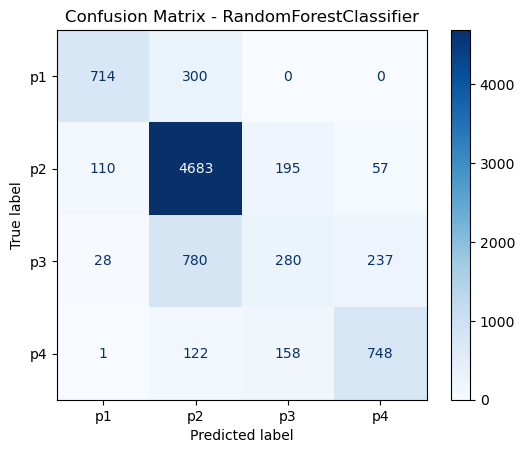

In [93]:
# Compute confusion matrix
labels = np.unique(y_test1)
cm = confusion_matrix(y_test1, y_pred1, labels = labels)

# Display nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["p1","p2","p3","p4"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RandomForestClassifier")
plt.show()


# RandomForestClassifier for accounting class imbalance

In [97]:
# Option 1: Let sklearn auto-balance
rf_classifier1 = RandomForestClassifier(class_weight='balanced',n_estimators = 200, random_state = 42)

rf_classifier1.fit(x_train1, y_train1)
y_pred2 = rf_classifier1.predict(x_test1)

accuracy1 = accuracy_score(y_test1, y_pred2)     # accuracy of complete model
print ()
print(f'Accuracy: {accuracy1}')
print ()
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test1, y_pred2)

for i, v in enumerate(['p1', 'p2', 'p3', 'p4']):      # i will iterate for position in list and v will iterate for class labels
    print(f"Class {v}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1_score[i]}")
    print()




Accuracy: 0.7634613098775704

Class p1:
Precision: 0.8524590163934426
Recall: 0.6666666666666666
F1 Score: 0.7482014388489209

Class p2:
Precision: 0.7862696443341605
Recall: 0.9421209117938553
F1 Score: 0.8571686203787195

Class p3:
Precision: 0.45
Recall: 0.19018867924528302
F1 Score: 0.2673740053050398

Class p4:
Precision: 0.7310344827586207
Recall: 0.7210884353741497
F1 Score: 0.726027397260274



In [98]:
# Option 2: If you want to give your own weights
weights = {
    'P1': 42064 / (4 * 4908),   # inverse frequency
    'P2': 42064 / (4 * 25452),
    'P3': 42064 / (4 * 6440),
    'P4': 42064 / (4 * 5264),
}


# Option 1: Let sklearn auto-balance
rf_classifier2 = RandomForestClassifier(class_weight = weights,n_estimators = 200, random_state = 42)

rf_classifier2.fit(x_train1, y_train1)
y_pred3 = rf_classifier2.predict(x_test1)

accuracy2 = accuracy_score(y_test1, y_pred3)     # accuracy of complete model
print ()
print(f'Accuracy: {accuracy2}')
print ()
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test1, y_pred3)

for i, v in enumerate(['p1', 'p2', 'p3', 'p4']):      # i will iterate for position in list and v will iterate for class labels
    print(f"Class {v}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1_score[i]}")
    print()


Accuracy: 0.7620349459170331

Class p1:
Precision: 0.8474148802017655
Recall: 0.6627218934911243
F1 Score: 0.7437742114001107

Class p2:
Precision: 0.7883686052324612
Recall: 0.9377601585728444
F1 Score: 0.8565996740901684

Class p3:
Precision: 0.45193929173693087
Recall: 0.20226415094339623
F1 Score: 0.2794577685088634

Class p4:
Precision: 0.7212475633528265
Recall: 0.7191448007774538
F1 Score: 0.7201946472019465



# now do SMOTE for class imbalanced dataset

In [99]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [100]:
from imblearn.over_sampling import SMOTE

In [101]:
# Suppose df is your dataset
y = df_encoded['Approved_Flag']
x = df_encoded. drop ( ['Approved_Flag'], axis = 1 )


# Train-test split
x_train2, x_test2, y_train2, y_test2 = train_test_split(x,y, test_size = 0.2, random_state = 42, stratify=y)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)   # default oversamples all minority classes
x_train_res, y_train_res = smote.fit_resample(x_train2, y_train2)

print("Before SMOTE:", y_train2.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Approved_Flag
P2    20362
P3     5152
P4     4211
P1     3926
Name: count, dtype: int64
After SMOTE: Approved_Flag
P4    20362
P3    20362
P1    20362
P2    20362
Name: count, dtype: int64


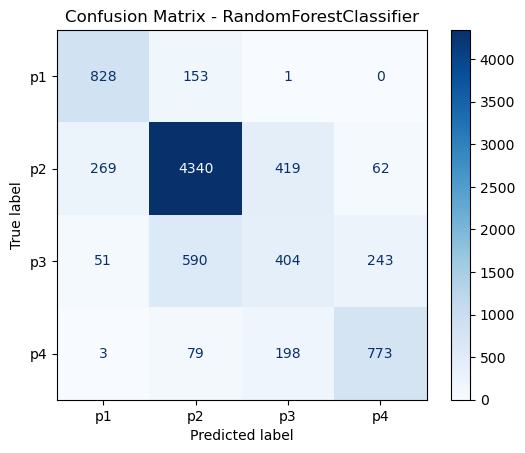

              precision    recall  f1-score   support

          P1       0.72      0.84      0.78       982
          P2       0.84      0.85      0.85      5090
          P3       0.40      0.31      0.35      1288
          P4       0.72      0.73      0.73      1053

    accuracy                           0.75      8413
   macro avg       0.67      0.69      0.67      8413
weighted avg       0.74      0.75      0.75      8413



In [105]:
from sklearn.metrics import classification_report, confusion_matrix

# Train on resampled dataset
rf_smote = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf_smote.fit(x_train_res, y_train_res)

# Evaluate on original test set
y_pred_smote = rf_smote.predict(x_test2)

cm_smote = confusion_matrix(y_test2, y_pred_smote,labels = labels)

# Display nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=["p1","p2","p3","p4"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RandomForestClassifier")
plt.show()


print(classification_report(y_test2, y_pred_smote))


# 2. XGB Classifier

In [52]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [53]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# model initialization

In [54]:
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax',  num_class=4)

In [55]:
x = df_encoded.drop(columns = ['Approved_Flag'], axis = 1 )
y = df_encoded['Approved_Flag']

# LAbel encoding for output Column

In [56]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)    # Converts text labels like 'P1', 'P2', etc. into numeric values like 0, 1, 2, 3.
                                                    # Required because XGBoost needs numeric labels for classification.


In [57]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y_encoded, test_size = 0.2, random_state = 42)

# model fitting

In [58]:
xgb_classifier.fit(x_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, ...)

In [59]:
y_pred2 = xgb_classifier.predict(x_test2)

# metrics Evaluation

In [60]:
accuracy = accuracy_score(y_test2, y_pred2)
print ()
print(f'Accuracy: {accuracy:.2f}')
print ()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test2, y_pred2)


Accuracy: 0.78



In [61]:
for i, v in enumerate(['p1', 'p2', 'p3', 'p4']):
    print(f"Class {v}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1_score[i]}")
    print()

Class p1:
Precision: 0.823906083244397
Recall: 0.7613412228796844
F1 Score: 0.7913890312660175

Class p2:
Precision: 0.8255418233924413
Recall: 0.913577799801784
F1 Score: 0.8673315769665035

Class p3:
Precision: 0.4756380510440835
Recall: 0.30943396226415093
F1 Score: 0.37494284407864653

Class p4:
Precision: 0.7342386032977691
Recall: 0.7356656948493683
F1 Score: 0.7349514563106796



# 3.Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
y = df_encoded['Approved_Flag']
x = df_encoded. drop ( ['Approved_Flag'], axis = 1 )

# train_test_split

In [64]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(x, y, test_size=0.2, random_state=42)

# model initialization

In [65]:
dt_model = DecisionTreeClassifier(max_depth=20, min_samples_split=10)

In [66]:
dt_model.fit(x_train3, y_train3)

DecisionTreeClassifier(max_depth=20, min_samples_split=10)

# prediction

In [67]:
y_pred3 = dt_model.predict(x_test3)

# metrics Evaluation

In [68]:

accuracy = accuracy_score(y_test3, y_pred3)
print ()
print(f"Accuracy: {accuracy:.2f}")
print ()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test3, y_pred3)

for i, v in enumerate(['p1', 'p2', 'p3', 'p4']):
    print(f"Class {v}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1_score[i]}")
    print()


Accuracy: 0.71

Class p1:
Precision: 0.7265547877591313
Recall: 0.7258382642998028
F1 Score: 0.7261963492846571

Class p2:
Precision: 0.8102643856920684
Recall: 0.8261645193260654
F1 Score: 0.818137206791638

Class p3:
Precision: 0.3452950558213716
Recall: 0.3267924528301887
F1 Score: 0.3357890655292749

Class p4:
Precision: 0.6457085828343313
Recall: 0.6287657920310982
F1 Score: 0.637124569177745



# Result --> XGBClassifier is giving best result now we will do hyperparameter tuning to increase its accuaracy

In [69]:
param_grid = {
   'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9],    # subsample ratio of columns when constructing each tree.
   'learning_rate'   : [0.001, 0.01, 0.05, 0.1, 0.5, 1],
   'max_depth'       : [3, 5, 8, 10],            # Depth of each tree
   'alpha'           : [1, 10, 50, 100],         # used for L1 regularization
   'n_estimators'    : [10, 50, 100, 200]        # no. of Tree to be used in model Building
}

In [70]:
index = 0

In [71]:
answers_grid = {
     'combination'       :[],
     'train_Accuracy'    :[],
     'test_Accuracy'     :[],
     'colsample_bytree'  :[],
     'learning_rate'     :[],
     'max_depth'         :[],
     'alpha'             :[],
     'n_estimators'      :[]
     }

# Loop through each combination of hyperparameters

In [72]:
#for colsample_bytree in param_grid['colsample_bytree']:
#    for learning_rate in param_grid['learning_rate']:
#        for max_depth in param_grid['max_depth']:
#            for alpha in param_grid['alpha']:
#                for n_estimators in param_grid['n_estimators']:

#                    index = index + 1
#                    # Define and train the XGBoost model
#                    xgb_model = xgb.XGBClassifier(objective            = 'multi:softmax',  
#                                                    num_class          =  4,
#                                                    colsample_bytree   = colsample_bytree,
#                                                    learning_rate      = learning_rate,
#                                                    max_depth          = max_depth,
#                                                    alpha              = alpha,
#                                                    n_estimators       = n_estimators)
#                    y = df_encoded['Approved_Flag']
#                    x = df_encoded. drop ( ['Approved_Flag'], axis = 1 )
#
#                    label_encoder = LabelEncoder()
#                    y_encoded = label_encoder.fit_transform(y)

#                    x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

#                    xgb_model.fit(x_train, y_train)

                           
                    # Predict on training and testing sets
#                    y_pred_train = xgb_model.predict(x_train)
#                    y_pred_test = xgb_model.predict(x_test)
           
       
                    # Calculate train and test results
#                    train_accuracy =  accuracy_score (y_train, y_pred_train)
#                    test_accuracy  =  accuracy_score (y_test , y_pred_test)

                    # Include into the lists
#                    answers_grid ['combination'].append(index)
#                    answers_grid ['train_Accuracy'].append(train_accuracy)
#                    answers_grid ['test_Accuracy'].append(test_accuracy)
#                    answers_grid ['colsample_bytree'].append(colsample_bytree)
#                    answers_grid ['learning_rate'].append(learning_rate)
#                    answers_grid ['max_depth'].append(max_depth)
#                    answers_grid ['alpha'].append(alpha)
#                    answers_grid ['n_estimators'].append(n_estimators)
       
       
                    # Print results for this combination
#                    print(f"Combination {index}")
#                    print(f"colsample_bytree: {colsample_bytree}, learning_rate: {learning_rate}, max_depth: {max_depth}, alpha: {alpha}, n_estimators: {n_estimators}")
#                    print(f"Train Accuracy: {train_accuracy:.2f}")
#                    print(f"Test Accuracy : {test_accuracy :.2f}")
#                    print("-" * 30)





In [73]:
 #len(answers_grid ['train_Accuracy'])

In [74]:
#max(answers_grid ['train_Accuracy'])

In [75]:
#max(answers_grid['test_Accuracy'])

In [76]:
#df3 = pd.DataFrame(answers_grid)

# test_Accuracy got increaases by very small amount and for the below combination

In [77]:
#xgb_best_parameters = df3.loc[df3['test_Accuracy'].idxmax()]

In [78]:
#xgb_best_parameters

# hyperparamter tuning for RandomForest

In [79]:
#rf_param_grid = {
#    'rf_n_estimators': [50, 100, 200, 300],
#    'rf_max_depth': [10, 20, 30, 50, None],
#    'rf_min_samples_split': [2, 5, 10],
#    'rf_min_samples_leaf': [1, 2, 4],
#    'rf_max_features': ['sqrt', 0.3, 0.5],
#    'rf_bootstrap': [True],
#}

In [80]:
#rf_index = 0

In [81]:
#rf_answers_grid = {
#     'combination'          : [],
#     'train_accuracy_rf'    : [],
#     'test_accuracy_rf'     : [],
#     'rf_max_depth'         : [],
#     'rf_max_features'      : [],
#     'rf_n_estimators'      : [],
#    'rf_min_samples_split'  : [],
#    'rf_min_samples_leaf'   : [],
#    'rf_bootstrap'          : []
#     }

In [82]:
#for rf_n_estimators in rf_param_grid['rf_n_estimators']:
#    for rf_max_depth in rf_param_grid['rf_max_depth']:
#        for rf_min_samples_split in rf_param_grid['rf_min_samples_split']:
#            for rf_min_samples_leaf in rf_param_grid['rf_min_samples_leaf']:
#                for rf_max_features in rf_param_grid['rf_max_features']:
#                    for rf_bootstrap in rf_param_grid['rf_bootstrap']:

#                        rf_index = rf_index + 1
                        # Define and train the XGBoost model
#                        rf_classifier_model = RandomForestClassifier( n_estimators          = rf_n_estimators,
#                                                                      max_depth             = rf_max_depth,
#                                                                      min_samples_split     = rf_min_samples_split ,
#                                                                      min_samples_leaf      = rf_min_samples_leaf,
#                                                                      max_features          = rf_max_features,
#                                                                      bootstrap             = rf_bootstrap,
#                                                                      random_state          = 42 )
                    
 #                       y = df_encoded['Approved_Flag']
 #                       x = df_encoded. drop ( ['Approved_Flag'], axis = 1 )

#                        x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x, y, test_size=0.2, random_state=42)

 #                       rf_classifier_model.fit(x_train_rf, y_train_rf)

                           
                        # Predict on training and testing sets
  #                      y_pred_train_rf = rf_classifier_model.predict(x_train_rf)
  #                      y_pred_test_rf = rf_classifier_model.predict(x_test_rf)
           
       
                        # Calculate train and test results
   #                     train_accuracy_rf =  accuracy_score (y_train_rf, y_pred_train_rf)
   #                     test_accuracy_rf  =  accuracy_score (y_test_rf , y_pred_test_rf)

                        # Include into the lists
    #                    rf_answers_grid ['combination'].append(rf_index)
    #                    rf_answers_grid ['train_accuracy_rf'].append(train_accuracy_rf)
     #                   rf_answers_grid ['test_accuracy_rf'].append(test_accuracy_rf)
      #                  rf_answers_grid ['rf_max_depth'].append(rf_max_depth)
    #                    rf_answers_grid ['rf_max_features'].append(rf_max_features)
    #                    rf_answers_grid ['rf_n_estimators'].append(rf_n_estimators)
    #                    rf_answers_grid ['rf_min_samples_split'].append(rf_min_samples_split)
    #                    rf_answers_grid ['rf_min_samples_leaf'].append(rf_min_samples_leaf)
    #                    rf_answers_grid ['rf_bootstrap'].append(rf_bootstrap)
       
       
                        # Print results for this combination
      #                  print(f"Combination {rf_index}")
     #                   print(f"rf_max_depth: {rf_max_depth}, rf_max_features: {rf_max_features}, rf_n_estimators: {rf_n_estimators}, rf_min_samples_split: {rf_min_samples_split}, rf_bootstrap: {rf_bootstrap}, rf_min_samples_leaf: {rf_min_samples_leaf}")
       #                 print(f"Train Accuracy: {train_accuracy_rf:.2f}")
       #                 print(f"Test Accuracy : {test_accuracy_rf :.2f}")
       #                 print("-" * 30)

In [83]:
#df_rf = pd.DataFrame(rf_answers_grid)

In [84]:
#rf_best_parameters = df_rf.loc[df_rf['test_accuracy_rf'].idxmax()]

In [85]:
#rf_best_parameters

In [96]:
df['Approved_Flag'].value_counts()

Approved_Flag
P2    25452
P3     6440
P4     5264
P1     4908
Name: count, dtype: int64